In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from vnstock import *

from Tools.function import *
from Tools.operators import *
from Tools.technical import *

from Fundamental.fndl import *

##### VN30

In [5]:
close = pd.read_csv("Data/close.csv", index_col="TradingDate", parse_dates=True)
high = pd.read_csv("Data/high.csv", index_col="TradingDate", parse_dates=True)
low = pd.read_csv("Data/low.csv", index_col="TradingDate", parse_dates=True)
open = pd.read_csv("Data/open.csv", index_col="TradingDate", parse_dates=True)
volume = pd.read_csv("Data/volume.csv", index_col="TradingDate", parse_dates=True)
returns = close.pct_change()

### Fundamental

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness         Margin
0 -0.040414 -0.221521  0.000179 -0.125957 -226253.812498
Overall of neutralize
     Return    Sharpe  Turnover   Fitness         Margin
0  0.034025  0.237437  0.000197  0.123878  172380.981793


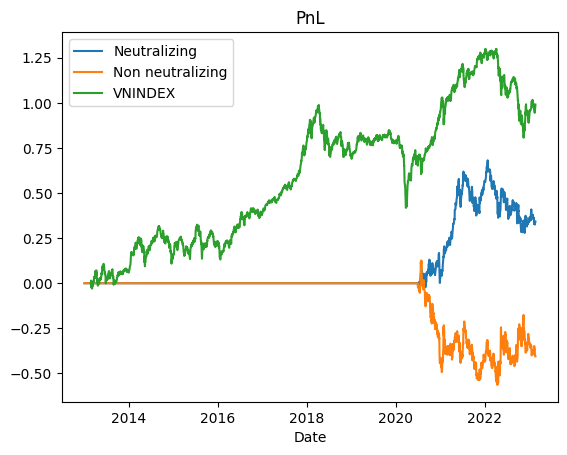

In [6]:
a= Stimulate(fndl("sales")/fndl("cost"))
a.plot_pnl()
a.overall()

In [7]:
a= Stimulate(rank(fndl("asset")/fndl("inventory")))

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness        Margin
0  0.079687  0.553987  0.000021  0.442321  3.832309e+06
Overall of neutralize
    Return    Sharpe  Turnover   Fitness         Margin
0  0.04559  0.436548  0.000081  0.263639  563783.834667


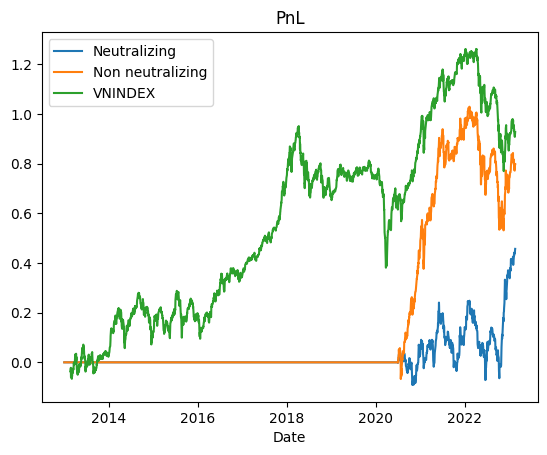

In [8]:
a.plot_pnl()
a.overall()

### Prob weight model

Overall of non neutralize
     Return   Sharpe  Turnover   Fitness      Margin
0  0.169819  1.45689  0.964032  0.611469  176.155048
Overall of neutralize
     Return    Sharpe  Turnover   Fitness    Margin
0  0.281644  1.863437  2.181574  0.669546  129.1015


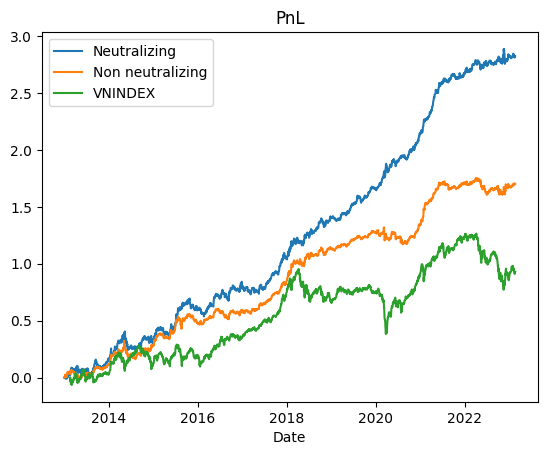

In [14]:
prob = prob_weights(volume,5)
kq = Stimulate(prob)
kq.plot_pnl()
kq.overall()

### Markowitz model

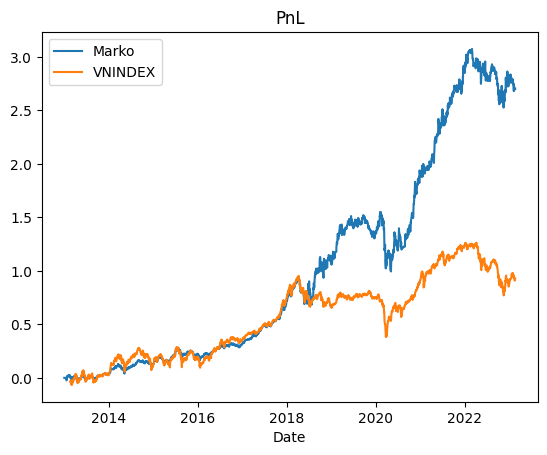

In [12]:
mark = marko_weights(close,lag=10)
a = Simresult(mark,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

### volum/adv20

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.294423  1.438323  0.389599  1.250356  755.709119
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.367706  2.268894  1.404519  1.160915  261.801767


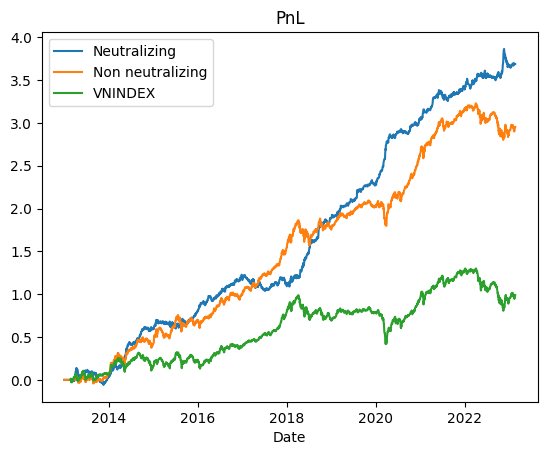

In [7]:
alpha1 =volume/ts_mean(ts_decay_linear(volume,30),20)
kq1 = Stimulate(alpha1)
kq1.plot_pnl()
kq1.overall()

##### MAE

Overall of non neutralize
     Return    Sharpe  Turnover  Fitness      Margin
0  0.286801  1.393488  0.418816  1.15314  684.790231
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.436995  2.785714  1.572834  1.468362  277.838986


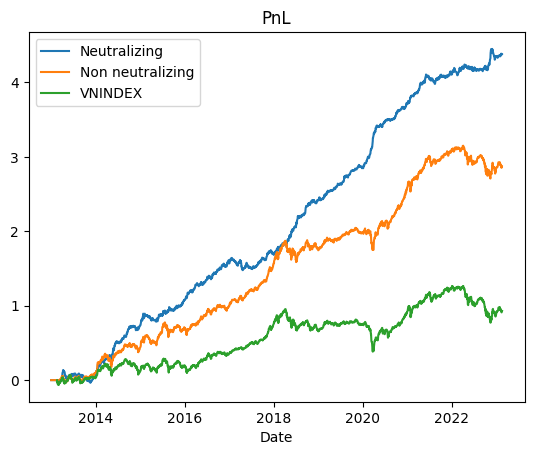

In [8]:
alpha2 = rank(mae(alpha1))
kq2 = Stimulate(alpha2)
kq2.plot_pnl()
kq2.overall()

##### MACD hist

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.294065  1.438456  0.402032  1.230234  731.446441
Overall of neutralize
     Return    Sharpe  Turnover  Fitness      Margin
0  0.450784  2.886271   1.50949  1.57727  298.633298


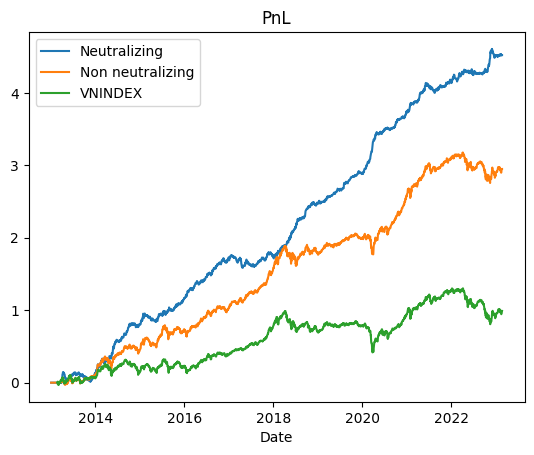

In [8]:
alpha3 = rank(macd_his(alpha1))
kq3 = Stimulate(alpha3)
kq3.plot_pnl()
kq3.overall()

##### Save weight

In [10]:
kq3.get_weights()

VHM    0.128889
ACB    0.120000
SSI    0.111111
FPT    0.102222
POW    0.093333
TPB    0.084444
VRE    0.075556
CTG    0.066667
NVL    0.057778
HDB    0.048889
STB    0.040000
GVR    0.031111
BVH    0.022222
VIB    0.013333
MSN    0.004444
MBB   -0.004444
HPG   -0.013333
PLX   -0.022222
VPB   -0.031111
VCB   -0.040000
BID   -0.048889
MWG   -0.057778
PDR   -0.066667
GAS   -0.075556
VNM   -0.084444
VIC   -0.093333
VJC   -0.102222
BCM   -0.111111
TCB   -0.120000
SAB   -0.128889
Name: 2023-02-20 00:00:00, dtype: float64


In [12]:
save_weights(kq3.neu,"2023-02-20")